# Anaysis for Optimising Personal Mibility Collect time
(for data science study)
### Perpose 
Analysis datas for optimising Personal Mibility Cycle collect  

### way of Anaysis
clustering cycle stations by latitude and longitude  
then for each cluster, regression cycle going out and comming in time  

we can get insight that there are two type of region

data sources https://www.kaggle.com/datasets/pronto/cycle-share-dataset?select=trip.csv  
#### <em>Data Set has problem</em>  
first 50000 line is duplicated and containing not readable by pandas

we did manualy remove fisrt 50000 lines

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,RobustScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows',None)

## PreProcessing And Curation

#### Data Definition

In [3]:
df_station = pd.read_csv("station.csv")
df_trip = pd.read_csv("trip.csv",parse_dates=['starttime','stoptime'])
df_station_GCS = pd.DataFrame(df_station.iloc[:,2:4],columns = ['lat','long']);

#### feature selection

In [4]:
df_trip.drop(['trip_id', 'bikeid', 'tripduration','from_station_name', 'to_station_name', 'usertype', 'gender', 'birthyear'],axis=1,inplace=True)
df_station.drop(['name', 'lat', 'long', 'install_date','install_dockcount', 'modification_date', 'current_dockcount','decommission_date'],axis=1,inplace=True)

#### feature creation

In [5]:
df_trip['day']=df_trip['stoptime'].dt.day.astype('category')
df_trip['starttime']=df_trip['stoptime'].dt.hour.astype('category')
df_trip['stoptime']=df_trip['stoptime'].dt.hour.astype('category')

#### scaling data

In [6]:
standard_scaler = StandardScaler().fit(df_station_GCS)
df_station_GCS = standard_scaler.transform(df_station_GCS)
scaled_df = pd.DataFrame(df_station_GCS,columns=['lat','long'])


## Clustering
scaled_df is scaled data of latitude and longitude  
then clustering these data by KMeans

### process clustering

In [7]:
model = KMeans(init="k-means++", n_clusters=4, n_init=12)
model.fit(scaled_df)
# save cluster id
df_station['cluster'] = model.labels_
model_center = model.cluster_centers_

### Cluster Distribution
we can see distribution on cycle station

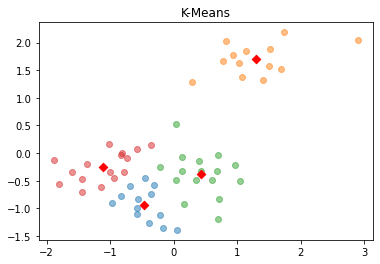

In [8]:
fig = plt.figure(figsize=(6, 4))
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(df_station['cluster']))))
ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(4), colors):
    my_members = (df_station['cluster'] == k)
    cluster_center = model_center[k]
    ax.scatter(scaled_df["long"][my_members], scaled_df["lat"][my_members],alpha = 0.5)
    ax.scatter(cluster_center[1], cluster_center[0],color = 'r', marker='D')

ax.set_title('K-Means')
plt.show()


### Process Clustered Result
replace cluster id and station id

In [9]:
len = len(df_station['station_id'])
for i in range(0,len):
    df_trip.replace(df_station['station_id'][i],df_station['cluster'][i],inplace=True)

df_trip['from_station_id']=df_trip['from_station_id'].astype('category')
df_trip['to_station_id']=df_trip['to_station_id'].astype('category')

grouped_df=df_trip.groupby(['to_station_id','stoptime']).count().reset_index()


### visualize clustering results

for each cluser, visualize docked cycle count  

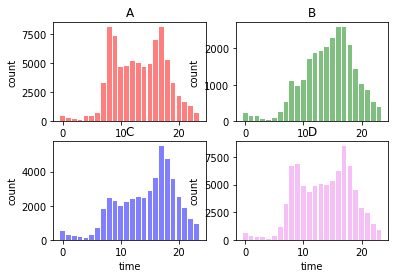

In [10]:
cluster_id = ['A','B','C','D']
color = ['r','g','b','violet']

for i in range(0,4):
    group = grouped_df.loc[grouped_df['to_station_id']==i]
    plt.subplot(2,2,i+1)
    plt.bar(group['stoptime'],group['starttime'],color=color[i],alpha=0.5)
    plt.title(cluster_id[i])
    plt.xlabel('time')
    plt.ylabel('count')
    
plt.show()


## regression

#### feature creation&selection

In [11]:
df=df_trip.drop(['starttime'],axis=1)
df=df.groupby(['to_station_id','stoptime','day']).count().reset_index()
df.drop(['day'],axis=1,inplace=True)

### repeated regression by cluster

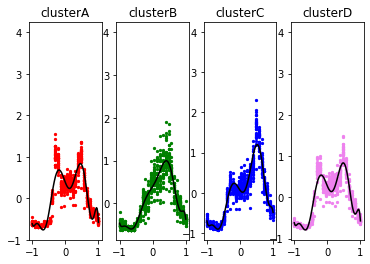

In [14]:
regression_results = []
fig, ax = plt.subplots(1,4)
for i in range(0,4):
    group = df.loc[df['to_station_id']==i]
    

    #scaling data
    standard_scaler = RobustScaler().fit(group)
    group = standard_scaler.transform(group)
    scaled_df = pd.DataFrame(group,columns=['to_station_id','stoptime','from_station_id'])

    #target Data and Learning Data
    df_x=scaled_df.drop(['to_station_id','from_station_id'],axis=1)
    df_y=scaled_df['from_station_id']
    
    #set degree for polynomial regression
    poly_features = PolynomialFeatures(degree=9, include_bias=True)

    #repeated regression 3 times
    results = []
    for j in range(0,3):
        X_train, X_test, y_train, y_test = train_test_split(df_x,df_y,test_size=0.3,shuffle=True)

        model = LinearRegression()
        x_poly = poly_features.fit_transform(X_train.values)
        model.fit(x_poly, y_train.values)

        X_new_poly = poly_features.transform(X_test.values)
        y_pred = model.predict(X_new_poly)
        regressed = {
            "R2 Score" : r2_score(y_test, y_pred),
            "MSE" : mean_squared_error(y_test, y_pred)
        }
        results.append(regressed)
    ret = {"cluster" :"cluster"+cluster_id[i], "output" : results }
    regression_results.append(ret)
    
    #visualize regression results
    ax[i].plot(1,4,i+1)
    ax[i].set_title("cluster"+cluster_id[i])
    ax[i].scatter(df_x, df_y, s=5,color=color[i])

    xx = np.linspace(-1, 1, 100).reshape(100, 1)
    X_new_poly = poly_features.transform(xx)
    y_pred = model.predict(X_new_poly)
    ax[i].plot(xx, y_pred, color='black')

We can see regression result of each cluster

In [13]:
regression_results


[{'cluster': 'clusterA',
  'output': [{'R2 Score': 0.8372713061522418, 'MSE': 0.05544439203395488},
   {'R2 Score': 0.861924143749941, 'MSE': 0.05076591759366633},
   {'R2 Score': 0.8576720738016981, 'MSE': 0.050043275673509226}]},
 {'cluster': 'clusterB',
  'output': [{'R2 Score': 0.8544012367544255, 'MSE': 0.04738162145653996},
   {'R2 Score': 0.8876314061976234, 'MSE': 0.03837236178482754},
   {'R2 Score': 0.8842942770758565, 'MSE': 0.043243951339320776}]},
 {'cluster': 'clusterC',
  'output': [{'R2 Score': 0.9112758979936013, 'MSE': 0.0408646363283157},
   {'R2 Score': 0.8858380404949089, 'MSE': 0.05265420051762277},
   {'R2 Score': 0.9012050481792636, 'MSE': 0.046213257212537044}]},
 {'cluster': 'clusterD',
  'output': [{'R2 Score': 0.8854797430830402, 'MSE': 0.03494610613230405},
   {'R2 Score': 0.8931307380764494, 'MSE': 0.03238840417949178},
   {'R2 Score': 0.8837108710810849, 'MSE': 0.03609224567939305}]}]